In [208]:
import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [209]:
classes = ["goodware", "malware"]
folders = {
    "goodware": "OpCode/goodware/",
    "malware": "OpCode/malware/",
}
labels = {
    "goodware": 0,
    "malware": 1,
}


In [210]:
X = []
y = []
for cls in classes:
    for text_filename in glob.glob(f"{folders[cls]}/*.txt"):
        with open(text_filename, mode="r", encoding="utf-8") as text_file:
            text_list = text_file.read()
            opcodes = text_list.split()[1:]
            X.append(opcodes)
            y.append(labels[cls])


In [211]:
mal_dataset = [opcodes for i, opcodes in enumerate(
    X) if y[i] == labels["malware"]]

opcode_frequency_dict = {}
for opcodes in mal_dataset:
    for opcode in opcodes:
        if opcode in opcode_frequency_dict:
            opcode_frequency_dict[opcode] += 1
        else:
            opcode_frequency_dict[opcode] = 1
opcode_frequency_dict = dict(sorted(opcode_frequency_dict.items(),
                                    key=lambda item: item[1],
                                    reverse=True))

opcode_rank_dict = {}
rank = 1
for key, _value in opcode_frequency_dict.items():
    opcode_rank_dict[key] = rank
    rank += 1

median = int(np.median([len(opcodes) for opcodes in mal_dataset]))

for i in range(len(X)):
    for j in range(len(X[i])):
        X[i][j] = opcode_rank_dict.get(X[i][j], 0)
    if len(X[i]) > median:
        X[i] = X[i][:median]
    else:
        X[i] += [0] * (median - len(X[i]))


In [212]:
opcode_frequency_df = pd.DataFrame(
    opcode_frequency_dict.items(), columns=["Opcode", "Frequency"]
)

opcode_rank_df = pd.DataFrame(
    opcode_rank_dict.items(), columns=["Opcode", "Rank"])

opcode_df = pd.merge(opcode_frequency_df, opcode_rank_df, on="Opcode")
opcode_df.set_index("Opcode", inplace=True)
opcode_df.head()


,Frequency,Rank
Opcode,,
MOV,787802,1
LDR,574914,2
ADD,250136,3
STR,235932,4
CMP,218929,5


In [213]:
estimators = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Knn = 1": KNeighborsClassifier(n_neighbors=1),
    "Knn = 3": KNeighborsClassifier(n_neighbors=3),
    "Knn = 5": KNeighborsClassifier(n_neighbors=5),
    "Adaboost": AdaBoostClassifier(),
}


In [214]:
classifier_accuracy_dict = {}
classifier_f1_dict = {}
classifier_matthews_corrcoef_dict = {}
for classifier, estimator in estimators.items():
    scores = {scoring: np.mean(score)
              for scoring, score
              in cross_validate(estimator, np.array(X), np.array(y),
                                scoring=("accuracy", "f1",
                                         "matthews_corrcoef"),
                                cv=10).items()}
    classifier_accuracy_dict[classifier] = scores["test_accuracy"]
    classifier_f1_dict[classifier] = scores["test_f1"]
    classifier_matthews_corrcoef_dict[classifier] = scores["test_matthews_corrcoef"]


In [215]:
classifier_accuracy_df = pd.DataFrame(classifier_accuracy_dict.items(),
                                      columns=["Classifier", "Accuracy"])

classifier_f1_df = pd.DataFrame(classifier_f1_dict.items(),
                                columns=["Classifier", "F-measure"])

classifier_df = pd.merge(classifier_accuracy_df, classifier_f1_df,
                         on="Classifier")
classifier_df.set_index("Classifier", inplace=True)
classifier_df


,Accuracy,F-measure
Classifier,,
SVM,0.986350,0.986190
Random Forest,0.984314,0.983823
Decision Tree,0.994155,0.993958
Knn = 1,0.976621,0.976374
Knn = 3,0.974661,0.974333
Knn = 5,0.966893,0.966792
Adaboost,0.990309,0.990258


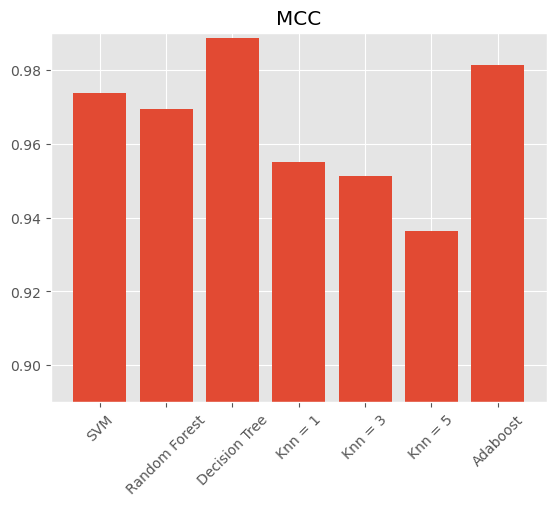

In [216]:
plt.title("MCC")
plt.xticks(rotation=45)
plt.ylim(0.89, 0.99)
plt.bar(tuple(classifier_matthews_corrcoef_dict.keys()),
        tuple(classifier_matthews_corrcoef_dict.values()))
plt.show()
